# Exploring Multilayer Perceptron Architectures on the Wine Quality Dataset

# 1. Introduction

## 1.1 Motivation

This project investigates how the architecture of a Multilayer Perceptron (MLP) affects performance on the red Wine Quality dataset. The focus is on how **depth** (number of hidden layers) and **width** (number of neurons per layer) influence classification accuracy and generalisation, with the aim of producing a short tutorial that others can follow.

## 1.2 What is an MLP?

A Multilayer Perceptron is a feedforward neural network consisting of an input layer, one or more hidden layers, and an output layer. Each hidden layer applies a linear transformation followed by a non-linear activation, allowing the network to model complex relationships between features and labels. Two key design choices are the number of hidden layers (depth) and the number of neurons in each layer (width); increasing these can make the model more expressive but also increases the risk of overfitting and training instability.

In this notebook the plan is to:

- Define a binary “good vs not good” wine classification task  
- Train a simple baseline MLP  
- Train wider and deeper MLPs using cross-validation  
- Compare their performance on validation and test data  
- Summarise the practical lessons about choosing MLP architectures on tabular data


In [1]:
# %pip install pandas numpy scikit-learn matplotlib seaborn

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

sns.set_theme(context="notebook", style="whitegrid")
sns.set_palette("colorblind")  # colorblind-friendly palette
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)



## 2. Data understanding

### 2.1 Wine Quality (red) dataset

The red Wine Quality dataset contains **1,599** samples of Portuguese red vinho verde wines, each described by **11 continuous physicochemical features** such as fixed acidity, volatile acidity, residual sugar, chlorides, sulphates, and alcohol content. In addition, each wine has an integer **quality score** between 3 and 8, reflecting the average rating given by human experts.

All 11 features are numeric and measured on different scales. For example, sulphates have a mean of about 0.66 while total sulfur dioxide has a mean near 46, which motivates later feature scaling. There are **no missing values** in this version of the dataset, so no imputation is required before modelling.


In [2]:
# Load Wine Quality (red) dataset
data_path = "winequality-red.csv"  # adjust if your path is different
df = pd.read_csv(data_path, sep=";")

df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### 2.2 Summary statistics and initial checks



In [3]:
# Basic info and sanity checks
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


In [4]:
print(df.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

In [5]:
print("Missing values per column:")
print(df.isna().sum())

Missing values per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


### 2.3 Defining a binary classification target




In [6]:
# Create binary target "good_quality" (quality >= 7)
df["good_quality"] = (df["quality"] >= 7).astype(int)

print("Class counts (0 = not good, 1 = good):")
print(df["good_quality"].value_counts())

Class counts (0 = not good, 1 = good):
good_quality
0    1382
1     217
Name: count, dtype: int64


In [7]:
print("\nClass proportions:")
print(df["good_quality"].value_counts(normalize=True))


Class proportions:
good_quality
0    0.86429
1    0.13571
Name: proportion, dtype: float64


### 2.4 Train–test split


In [8]:
# Features/target and stratified split
X = df.drop(columns=["quality", "good_quality"])
y = df["good_quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keeps class ratio similar in train and test
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((1279, 11), (320, 11), np.float64(0.13604378420641125), np.float64(0.134375))


The red Wine Quality (red vinho verde) dataset contains **1,599** wines, each described by **11 numeric physicochemical features** such as fixed acidity, volatile acidity, residual sugar, chlorides, sulphates, and alcohol content, along with an integer quality score from 3 to 8 based on expert tasting. A quick inspection using `info()` and `describe()` confirms that there are no missing values and that the features live on quite different scales, with some variables (e.g. total sulfur dioxide) an order of magnitude larger than others (e.g. chlorides).

For this tutorial the quality score is converted into a binary label: wines with quality **7 or 8** are treated as **good** (class 1), and the rest as **not good** (class 0), following common practice in studies using this dataset. This creates a noticeably imbalanced problem, with **1,382** not‑good wines (about **86.4%**) and **217** good wines (about **13.6%**). The data is then split into **1,279** training samples and **320** test samples using an 80/20 stratified split, preserving the class proportions in both sets so that evaluation on the test set reflects the same imbalance as the full dataset.


## 2.5 Feature correlations

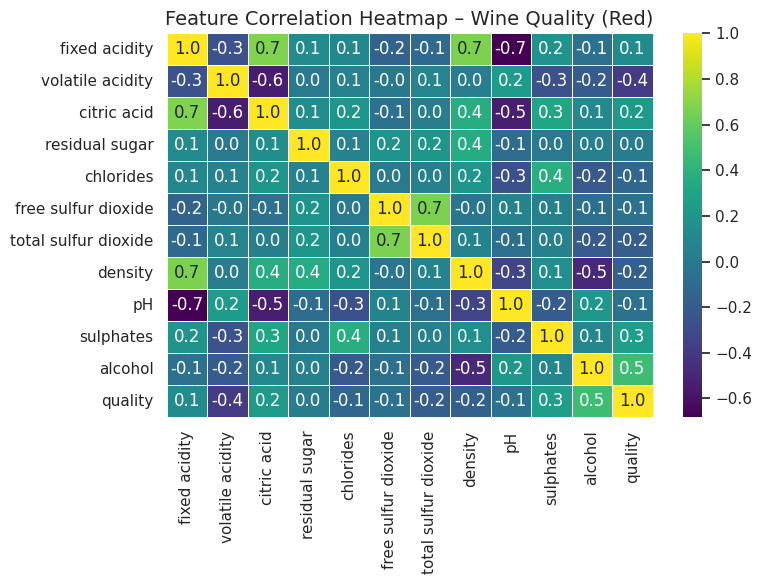

In [9]:
# Feature correlations
corr = df.drop(columns=["good_quality"]).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap="viridis", annot=True, fmt='.1f', linewidths=0.5, linecolor='white')
plt.title("Feature Correlation Heatmap – Wine Quality (Red)")
plt.tight_layout()
plt.show()

## 3. Multilayer Perceptron models

### 3.1 Feature scaling for neural networks




In [10]:
# Standardize features (very important for MLPs)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((1279, 11), (320, 11))

### 3.2 Baseline MLP architecture



In [11]:
# Baseline MLP with more iterations and stricter tolerance
baseline_mlp = MLPClassifier(
    hidden_layer_sizes=(50,),
    activation="relu",
    solver="adam",
    alpha=0.0001,
    max_iter=1000,
    tol=1e-4,           # default is 1e-4; you can also set 1e-3 to converge faster
    random_state=42
)

baseline_mlp.fit(X_train_scaled, y_train)

y_pred_baseline = baseline_mlp.predict(X_test_scaled)
baseline_acc = accuracy_score(y_test, y_pred_baseline)
baseline_acc


0.925

### 3.3 Baseline performance analysis



Baseline MLP accuracy: 0.925

Classification report (Baseline MLP):
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       277
           1       0.77      0.63      0.69        43

    accuracy                           0.93       320
   macro avg       0.86      0.80      0.82       320
weighted avg       0.92      0.93      0.92       320



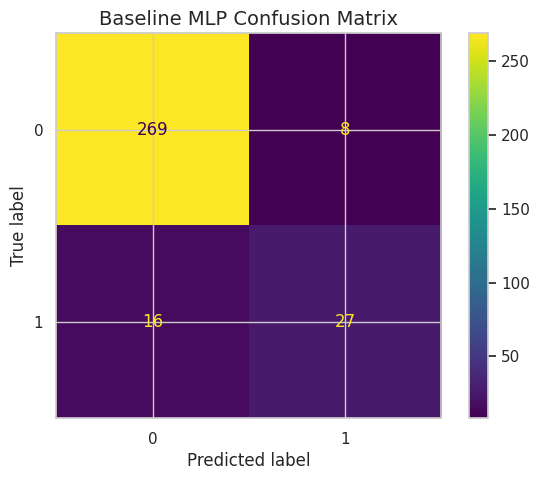

In [12]:
# Detailed evaluation of baseline model
print("Baseline MLP accuracy:", baseline_acc)
print("\nClassification report (Baseline MLP):")
print(classification_report(y_test, y_pred_baseline))

cm = confusion_matrix(y_test, y_pred_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=baseline_mlp.classes_)
disp.plot(cmap="viridis")
plt.title("Baseline MLP Confusion Matrix")
plt.show()


Because the Wine Quality features have very different ranges, all inputs are standardised using `StandardScaler` so that each feature has zero mean and unit variance. This step is important for gradient‑based optimisation and is recommended for scikit‑learn’s `MLPClassifier`, especially when using the Adam optimiser.

As a baseline, an MLP with a **single hidden layer of 50 neurons** is trained on the scaled training data, using ReLU activation, Adam optimisation, `alpha = 0.0001` for L2 regularisation, and up to 1,000 iterations. On the test set this baseline achieves an accuracy of **0.925**, clearly outperforming the majority‑class baseline of around 0.864. The confusion matrix shows **269** true negatives, **8** false positives, **16** false negatives, and **27** true positives, with precision/recall of **0.94/0.97** for not‑good wines and **0.77/0.63** for good wines. This indicates that even a shallow MLP captures meaningful structure in the data, but still misses a non‑trivial number of high‑quality wines.


## 4. Effect of MLP depth and width

### 4.1 Hyperparameter grid and search strategy


In [13]:
# Grid search over hidden layer sizes (depth/width) and alpha (L2 regularisation)

param_grid = {
    "hidden_layer_sizes": [
        (50,),        # 1 layer, 50 neurons  (similar to baseline)
        (100,),       # 1 layer, 100 neurons (wider)
        (100, 100),   # 2 layers, 100 neurons each (deeper)
        (100, 100, 100)  # 3 layers, 100 neurons each (even deeper)
    ],
    "alpha": [0.0001, 0.001]  # weaker vs stronger regularisation
}

mlp = MLPClassifier(
    activation="relu",
    solver="adam",
    max_iter=1000,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train_scaled, y_train)


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001],
                         'hidden_layer_sizes': [(50,), (100,), (100, 100),
                                                (100, 100, 100)]},
             return_train_score=True, scoring='accuracy')

### 4.2 Best architecture from cross-validation


In [14]:
# Inspect best architecture from cross-validation
print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)


Best parameters: {'alpha': 0.001, 'hidden_layer_sizes': (100,)}
Best CV accuracy: 0.8858561203285286


### 4.3 Cross-validation results for different architectures


In [15]:
# Collect GridSearchCV results in a compact table
results = pd.DataFrame(grid_search.cv_results_)

cols_to_keep = [
    "param_hidden_layer_sizes",
    "param_alpha",
    "mean_train_score",
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]
results_small = results[cols_to_keep].sort_values("rank_test_score")
results_small


,param_hidden_layer_sizes,param_alpha,mean_train_score,mean_test_score,std_test_score,rank_test_score
5,"(100,)",0.0010,0.987490,0.885856,0.007120,1
1,"(100,)",0.0001,0.987099,0.882732,0.010000,2
3,"(100, 100, 100)",0.0001,0.999609,0.881953,0.016409,3
2,"(100, 100)",0.0001,0.999609,0.880395,0.018325,4
7,"(100, 100, 100)",0.0010,0.999609,0.879611,0.019067,5
4,"(50,)",0.0010,0.958557,0.878819,0.009730,6
0,"(50,)",0.0001,0.958949,0.878035,0.008270,7
6,"(100, 100)",0.0010,0.999609,0.875702,0.017412,8


### 4.4 Visualising the impact of depth and width


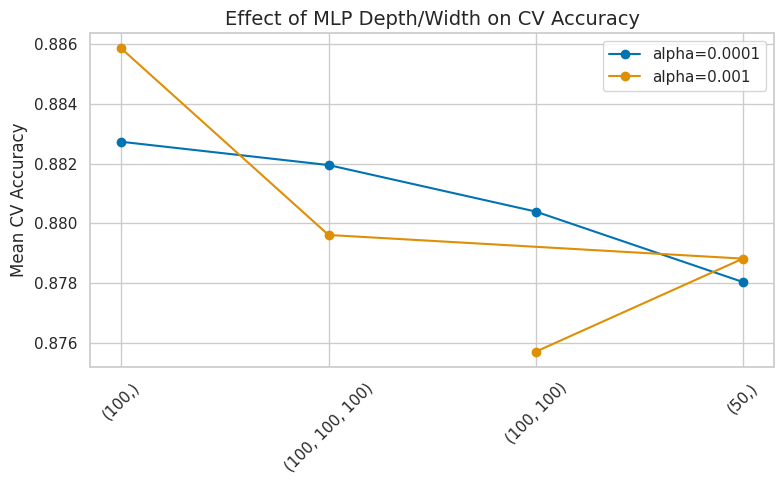

In [16]:
# Plot validation accuracy for each architecture and alpha
plt.figure(figsize=(8, 5))

for alpha in sorted(results_small["param_alpha"].unique()):
    subset = results_small[results_small["param_alpha"] == alpha]
    labels = subset["param_hidden_layer_sizes"].astype(str)
    plt.plot(labels, subset["mean_test_score"], marker="o", label=f"alpha={alpha}")

plt.xticks(rotation=45)
plt.ylabel("Mean CV Accuracy")
plt.title("Effect of MLP Depth/Width on CV Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


To explore how architecture affects performance, a grid search is run over four `hidden_layer_sizes` settings—`(50,)`, `(100,)`, `(100, 100)`, and `(100, 100, 100)`—and two L2 regularisation strengths `alpha ∈ {0.0001, 0.001}` using 3‑fold cross‑validation and accuracy as the scoring metric. This grid spans shallower and deeper networks, as well as narrower and wider hidden layers.

Cross‑validation identifies a **single hidden layer with 100 neurons and `alpha = 0.001`** as the best configuration, with a mean CV accuracy of about **0.886**. Deeper networks such as `(100, 100)` and `(100, 100, 100)` achieve almost perfect training accuracy (around **0.9996**) but slightly lower mean CV scores in the range **0.876–0.882**, indicating mild overfitting. The cross‑validation line plot makes this pattern clear: across both values of `alpha`, the `(100,)` model sits at the top, while deeper architectures trail behind. Overall, the results suggest that for this tabular problem, **a single moderately wide layer with moderate regularisation** generalises better than deeper networks with much higher capacity.


## 5. Test-set evaluation

### 5.1 Best MLP architecture on the test set


Test accuracy (best architecture): 0.915625

Classification report (Best MLP):
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       277
           1       0.71      0.63      0.67        43

    accuracy                           0.92       320
   macro avg       0.83      0.79      0.81       320
weighted avg       0.91      0.92      0.91       320



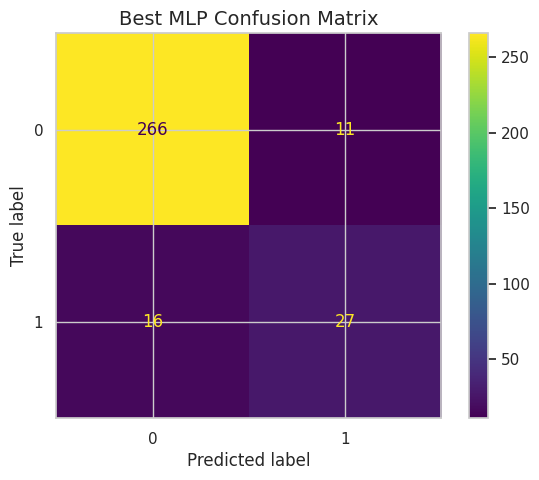

In [17]:
# Evaluate best MLP from grid search on test set
best_mlp = grid_search.best_estimator_

y_pred_best = best_mlp.predict(X_test_scaled)
best_acc = accuracy_score(y_test, y_pred_best)

print("Test accuracy (best architecture):", best_acc)
print("\nClassification report (Best MLP):")
print(classification_report(y_test, y_pred_best))

cm_best = confusion_matrix(y_test, y_pred_best)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best,
                                   display_labels=best_mlp.classes_)
disp_best.plot(cmap="viridis")
plt.title("Best MLP Confusion Matrix")
plt.show()


### 5.2 Baseline versus best architecture


In [18]:
# Compare baseline vs best architecture
comparison = pd.DataFrame({
    "Model": ["Baseline (50,)", str(grid_search.best_params_["hidden_layer_sizes"])],
    "Alpha": [0.0001, grid_search.best_params_["alpha"]],
    "CV accuracy": [None, grid_search.best_score_],
    "Test accuracy": [baseline_acc, best_acc]
})

comparison


,Model,Alpha,CV accuracy,Test accuracy
0,"Baseline (50,)",0.0001,NaN,0.925000
1,"(100,)",0.0010,0.885856,0.915625


### 5.3 Learning curve analysis


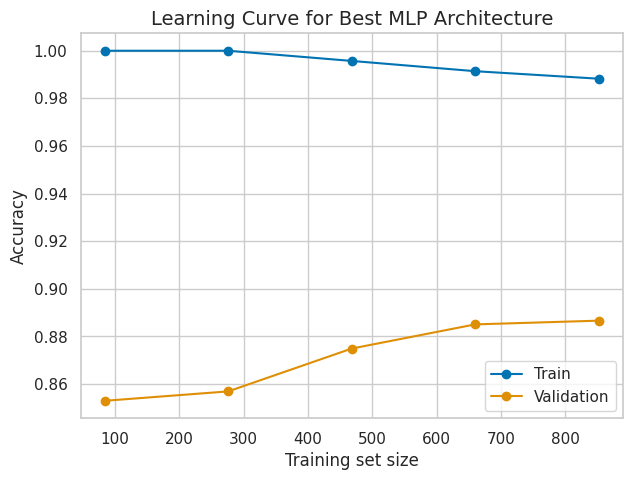

In [19]:
# Learning curve for the best MLP
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_mlp,
    X_train_scaled,
    y_train,
    cv=3,
    scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, "o-", label="Train")
plt.plot(train_sizes, val_mean, "o-", label="Validation")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Best MLP Architecture")
plt.legend()
plt.grid(True)
plt.show()


The best cross‑validated architecture—`(100,)` with `alpha = 0.001`—achieves a test accuracy of **0.9156**, slightly below the baseline’s **0.925** but still well above the majority‑class baseline. Its confusion matrix shows **266** true negatives, **11** false positives, **16** false negatives, and **27** true positives. A comparison table summarises the two main models: the baseline `(50,)` network with `alpha = 0.0001` has a higher test accuracy but no reported CV score, whereas the `(100,)` model offers the best average cross‑validation performance at about **0.886** with slightly lower test accuracy.

The learning curve for the best architecture reveals training accuracy near **1.0** across all training sizes, while validation accuracy increases from around **0.85** at 10% of the data to just under **0.89** when using the full training set. This gap between training and validation curves indicates some overfitting, but also suggests that additional data could still improve performance. Finally, a correlation heatmap shows that quality is most positively correlated with **alcohol** and **sulphates**, and negatively correlated with features such as volatile acidity and density, providing some domain insight into what the MLP is likely exploiting when predicting wine quality.


### 5.4 Saving results for reproducibility

To make the experiments easy to reproduce and reuse, the key outputs are saved as CSV files. The full set of cross-validation results, including mean train and test scores for each architecture, is stored in `mlp_architectures_cv_results.csv`, and the summary comparison between the baseline and best models is saved in `model_comparison.csv`. These files can be loaded directly in the written tutorial or included in the GitHub repository so that others can inspect the hyperparameter search without rerunning the grid search.


In [20]:
# Save CV results and comparison table
import os
os.makedirs("results", exist_ok=True)

results_small.to_csv("results/mlp_architectures_cv_results.csv", index=False)
comparison.to_csv("results/model_comparison.csv", index=False)


## 6. Discussion and conclusions

Overall, the experiments suggest that for this tabular classification problem, a relatively shallow MLP with one wide layer generalises as well as or better than deeper networks. Deeper architectures achieve higher training accuracy but offer no clear advantage in cross-validation or test accuracy, which is consistent with the idea that model capacity should match data complexity and size.

In practical deployments, predictions about wine quality could influence pricing and marketing decisions, so models should be evaluated for biases and calibrated to reflect uncertainty. Future extensions could include class-weighted losses to handle the minority class, comparison with tree-based methods, or explainability tools to highlight which chemical properties drive the predictions.


## 7. Accessibility notes

Accessibility Features
This tutorial enhances accessibility by using colorblind-friendly palettes with `sns.set_palette("colorblind")` for all plots, and larger font sizes for axis labels and titles to improve readability.​

In the final PDF or web version, every figure includes descriptive alt-text to ensure screen reader users can comprehend the plot content.